# Deep Learning Project Notebook
This project leverages deep learning techniques to predict the United States GDP Growth Rate (%), utilizing a comprehensive set of economic indicators.
By combining advanced sequential models such as GRU, LSTM, Transformer, TCN, and WaveNet - this study aims to uncover temporal patterns and enhance the accuracy of economic forecasting.

## **Introduction**
1. Incorporating BERT and GPT for advanced contextual understanding in economic trend analysis.
2. Leveraging Deep Learning techniques, including GRU, LSTM, Transformer, TCN, and WaveNet, to predict GDP Growth Rate, a key macroeconomic metric.
3. Highlighting the significance of sequential modeling and temporal pattern-recognition in understanding economic trends.
4. Utilizing advanced methodologies in feature engineering and neural network optimization to enhance forecasting accuracy.

In [1]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings


In [2]:
# Install Required Libraries (if not already installed)
!pip install transformers sentence-transformers faiss-cpu gradio beautifulsoup4 requests


In [3]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
import faiss
import numpy as np
import gradio as gr
import requests
from bs4 import BeautifulSoup
import warnings

print("Welcome! Is there anything you'd like to explore before diving into our deep learning flow?")
print("\n\n---------------------------------------------------------\n\n")

# Suppress Hugging Face warnings (optional)
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub.utils._auth")

# List of URLs to scrape
urls = [
    "https://en.wikipedia.org/wiki/Gross_domestic_product",
    "https://en.wikipedia.org/wiki/Inflation",
    "https://en.wikipedia.org/wiki/Unemployment",
    "https://en.wikipedia.org/wiki/United_States_Treasury_security",
    "https://en.wikipedia.org/wiki/Interest",
    "https://tradingeconomics.com/united-states/non-farm-payrolls",
    "https://fred.stlouisfed.org/series/INDPRO",
    "https://www.bea.gov/data/personal-consumption-expenditures-price-index",
    "https://simple.wikipedia.org/wiki/Expenditure",
    "https://tradingeconomics.com/united-states/leading-economic-index",
    "https://en.wikipedia.org/wiki/Consumer_price_index",
    "https://en.wikipedia.org/wiki/Macroeconomics",
    "https://www.fe.training/free-resources/portfolio-management/macroeconomic-indicators/",
    "https://www.indeed.com/career-advice/career-development/macroeconomics-factors"
]

# Function to scrape content from a single URL
def scrape_url(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        # Extract all paragraphs and return as a list of strings
        paragraphs = [p.text.strip() for p in soup.find_all("p") if p.text.strip()]
        return paragraphs
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return []

documents = []

# Scrape all URLs and add content to the documents list
for url in urls:
    new_content = scrape_url(url)
    documents.extend(new_content)


# Load Sentence-BERT for embeddings
retriever_model = SentenceTransformer('all-MiniLM-L6-v2')
# Generate embeddings for all documents
embeddings = retriever_model.encode(documents)
# Build FAISS (= Facebook AI Similarity Search) index for retrieval
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# Retrieval Function
def retrieve(query, k=2):
    query_embedding = retriever_model.encode([query])
    distances, indices = index.search(np.array(query_embedding), k)
    return [documents[i] for i in indices[0]]

# Load GPT-2 tokenizer and model, for Answer Generation
tokenizer = AutoTokenizer.from_pretrained("gpt2")
generator_model = AutoModelForCausalLM.from_pretrained("gpt2")

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Answer Generation Function
def generate_answer(query):
    # Retrieve the most relevant context
    context = retrieve(query)
    # Combine the query and context into a single input text
    input_text = f"Answer the question: {query}\nContext: {' '.join(context[:2])}"  # Use top 2 retrieved documents
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024)
    # Generate the answer using GPT-2
    outputs = generator_model.generate(
        **inputs,
        max_length=200,            # Limit the output length
        do_sample=True,            # Enable sampling for diverse outputs
        temperature=0.7,           # Control randomness
        top_k=50,                  # Consider top 50 tokens by probability
        top_p=0.9,                 # Use tokens with cumulative probability 0.9
        repetition_penalty=1.2     # Penalize repetitive phrases
    )
    # Decode and return the generated answer
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Gradio Interface
# Function to be used in Gradio
def ask_bot(query):
    if not query.strip():
        return "Please ask a question to get started!"

    answer = generate_answer(query)
    return f"{answer}\n\nThanks for exploring! Are there any additional questions you'd like to ask?"

# Create a Gradio interface
interface = gr.Interface(
    fn=ask_bot,
    inputs="text",
    outputs="text",
    title="Economic Insights Bot",
    description="Ask questions about economic concepts like GDP, inflation, and more!",
    flagging_mode="never"  # Disable flagging for a cleaner UI
)

# Launch the Gradio Interface
interface.launch()



Welcome! Is there anything you'd like to explore before diving into our deep learning flow?


---------------------------------------------------------


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2ae59004c6c2566e17.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
!pip install --upgrade pandas-datareader
!pip install fredapi


### **1.1 Import Modules**

In [5]:
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
import torch
import torch.optim as optim
from fredapi import Fred
import numpy as np


### **1.2 Load Economic Indicators Dataset**

In [6]:
# Check if the dataset file exists and load it
path = kagglehub.dataset_download("heidarmirhajisadati/global-economic-indicators-dataset-2010-2023")
file_path = os.path.join(path, os.listdir(path)[0])  # Get the first file

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Check the dataset download.")

# Load the dataset
print("Loading dataset...")
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("\nDataset Info:")
data.info()


Loading dataset...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   500 non-null    object 
 1   Country                500 non-null    object 
 2   Inflation Rate (%)     500 non-null    float64
 3   GDP Growth Rate (%)    500 non-null    float64
 4   Unemployment Rate (%)  500 non-null    float64
 5   Interest Rate (%)      500 non-null    float64
 6   Stock Index Value      500 non-null    float64
dtypes: float64(5), object(2)
memory usage: 27.5+ KB


### **1.3 Preprocess Economic Indicators Dataset**

In [7]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())
print("\nNo NaN treatment is required !")

# Only USA-related data
usa_data = data[data['Country'] == 'USA']

# Display the first 5 rows of the dataset
print("\nFirst 5 rows:\n")
usa_data.head()


Missing Values:
Date                     0
Country                  0
Inflation Rate (%)       0
GDP Growth Rate (%)      0
Unemployment Rate (%)    0
Interest Rate (%)        0
Stock Index Value        0
dtype: int64

No NaN treatment is required !

First 5 rows:



,Date,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
2,2010-01-31,USA,7.46,4.84,2.64,6.39,13129.10
7,2010-02-28,USA,3.13,4.82,9.32,-0.66,10638.13
9,2010-03-31,USA,7.20,-1.48,4.10,8.22,6067.71
17,2010-06-30,USA,5.56,0.87,4.54,3.34,2104.14
35,2011-01-31,USA,0.09,-1.82,11.92,-0.06,31674.37


In [8]:
# Ensure Date column is in datetime format and set it as the index
usa_data = usa_data.copy()  # Explicitly create a copy to avoid ambiguity
usa_data['Date'] = pd.to_datetime(usa_data['Date'])
usa_data = usa_data.set_index('Date')

# Drop duplicate dates, keeping the first occurrence
usa_data = usa_data[~usa_data.index.duplicated(keep='first')]

# Resample to include all months (last day of each month)
usa_data = usa_data.resample('M').asfreq()

# Fill missing numeric columns with linear interpolation
usa_data = usa_data.interpolate(method='linear')

# Forward fill remaining "country" missing values
usa_data = usa_data.fillna(method='ffill')
usa_data = usa_data.fillna(method='bfill')

# Drop Stock Index Value as it is now irrelevant for 'GDP Growth Rate (%)'
if 'Stock Index Value' in usa_data.columns:
    usa_data = usa_data.drop(columns=['Stock Index Value'])

# Verify the final dataset
print("\nData after handling missing dates and values:\n")
usa_data.head()



Data after handling missing dates and values:



,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%)
Date,,,,,
2010-01-31,USA,7.460000,4.840000,2.640000,6.390000
2010-02-28,USA,3.130000,4.820000,9.320000,-0.660000
2010-03-31,USA,7.200000,-1.480000,4.100000,8.220000
2010-04-30,USA,6.653333,-0.696667,4.246667,6.593333
2010-05-31,USA,6.106667,0.086667,4.393333,4.966667


### **1.4 Load Additional FRED Features**

In [9]:
# Set FRED API key
fred_api_key = "9b7055aac3cb6bc9ec7b436a64703ff1"
fred = Fred(api_key=fred_api_key)

# Define the time range for data retrieval
start_date = '2010-01-01'
end_date = '2023-09-30'

# Define FRED symbols and their descriptions
external_features = {
    '10-Year Treasury Yield': 'GS10',  # Long-term interest rates
    'Nonfarm Payrolls': 'PAYEMS',  # Employment trends
    'Industrial Production': 'INDPRO',  # Economic output
    'Personal Consumption Expenditures': 'PCE',  # Consumer spending
    'US Leading Index': 'USSLIND',  # Economic outlook
    'Consumer Price Index (CPI)': 'CPIAUCSL',  # Inflation measure
}

# Fetch data from FRED and aggregate to monthly by resampling
external_data = {}
for desc, symbol in external_features.items():
    try:
        print(f"Fetching data for {desc} ({symbol})...")
        data = fred.get_series(symbol, observation_start=start_date, observation_end=end_date)

        # Convert to DataFrame and resample to monthly
        data = data.to_frame(name=desc).resample('M').mean()
        external_data[desc] = data
    except Exception as e:
        print(f"Failed to fetch {desc}. Error: {e}")

#10-Year Treasury Yield (GS10): Typically daily but resampled to monthly.
#Crude Oil Prices (WTI) (DCOILWTICO): Typically daily, resampled to monthly.
#Trade-Weighted US Dollar (DTWEXBGS): Typically weekly, resampled to monthly.
#Consumer Price Index (CPI) (CPIAUCSL): Already reported as monthly by FRED, so resampling won't change it.
#Unemployment Rate (UNRATE): Already reported as monthly by FRED.

# Combine data into a single DataFrame
external_df = pd.concat(external_data.values(), axis=1)

print("\n\nFetched data preview:\n")
external_df.head()


Fetching data for 10-Year Treasury Yield (GS10)...
Fetching data for Nonfarm Payrolls (PAYEMS)...
Fetching data for Industrial Production (INDPRO)...
Fetching data for Personal Consumption Expenditures (PCE)...
Fetching data for US Leading Index (USSLIND)...
Fetching data for Consumer Price Index (CPI) (CPIAUCSL)...


Fetched data preview:



,10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI)
2010-01-31,3.73,129795.0,89.1897,10056.1,0.54,217.488
2010-02-28,3.69,129702.0,89.5046,10093.4,0.76,217.281
2010-03-31,3.73,129865.0,90.1356,10156.0,1.10,217.353
2010-04-30,3.85,130115.0,90.4607,10182.3,1.14,217.403
2010-05-31,3.42,130645.0,91.7014,10210.8,1.42,217.290


### **1.5 Preprocess The Dataset For New FRED Features + Merge For a Unified Dataset**

In [10]:
# Ensure the indices are datetime and aligned
external_df.index = pd.to_datetime(external_df.index)
usa_data.index = pd.to_datetime(usa_data.index)

# Merge external data with the main dataset
merged_data = usa_data.merge(external_df, left_index=True, right_index=True, how='left')

# Fill missing values with interpolation or forward/backward fill
merged_data = merged_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

usa_data = merged_data.drop(columns=['Country'])

# Move GDP Growth Rate (%) to the last column for visual purposes
columns = [col for col in usa_data.columns if col != 'GDP Growth Rate (%)'] + ['GDP Growth Rate (%)']
usa_data = usa_data[columns]

# Preview the merged dataset
print("\nMerged dataset preview:\n")
usa_data.head()



Merged dataset preview:



,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI),GDP Growth Rate (%)
Date,,,,,,,,,,
2010-01-31,7.460000,2.640000,6.390000,3.73,129795.0,89.1897,10056.1,0.54,217.488,4.840000
2010-02-28,3.130000,9.320000,-0.660000,3.69,129702.0,89.5046,10093.4,0.76,217.281,4.820000
2010-03-31,7.200000,4.100000,8.220000,3.73,129865.0,90.1356,10156.0,1.10,217.353,-1.480000
2010-04-30,6.653333,4.246667,6.593333,3.85,130115.0,90.4607,10182.3,1.14,217.403,-0.696667
2010-05-31,6.106667,4.393333,4.966667,3.42,130645.0,91.7014,10210.8,1.42,217.290,0.086667


## **2. Time-Series Modeling Using : GRU, LSTM**

In [11]:
# Data Preperation

usa_data_for_Time_Series_Modeling = usa_data

# Shift 'GDP Growth Rate (%)' column upwards by one row to predict next day's price
usa_data_for_Time_Series_Modeling['GDP Growth Rate (%)'] = usa_data_for_Time_Series_Modeling['GDP Growth Rate (%)'].shift(-1)

# Drop the Date column as it is not a feature
usa_data_for_Time_Series_Modeling = usa_data_for_Time_Series_Modeling.drop(columns=['Date', 'Country'], errors='ignore')

# Separate the last row for future prediction
future_row_for_time_series_modeling = usa_data_for_Time_Series_Modeling.iloc[[-1]]
usa_data_for_Time_Series_Modeling = usa_data_for_Time_Series_Modeling.iloc[:-1]

print("\nRow for future prediction:\n")
future_row_for_time_series_modeling


Row for future prediction:



,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI),GDP Growth Rate (%)
Date,,,,,,,,,,
2023-09-30,7.32,9.36,4.58,4.38,156667.0,103.3081,19024.9,1.72,307.288,NaN


### **2.1 GRU Architecture for Time-Series Forecasting**

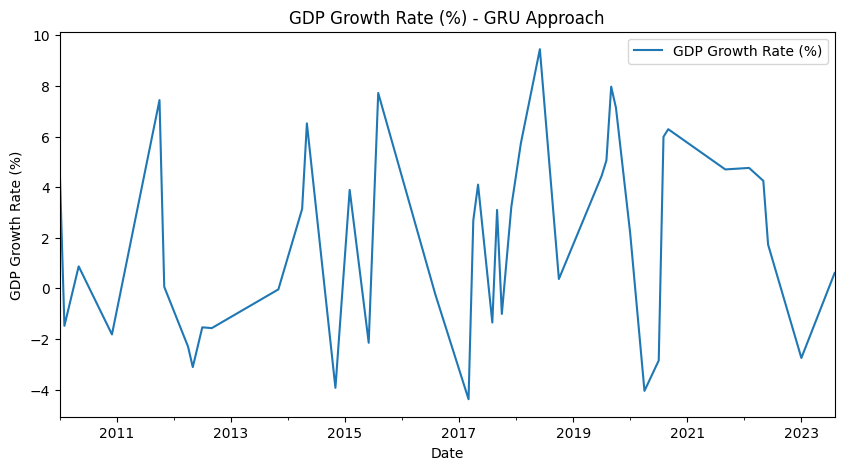

Train size: 152, Test size: 12
X_train_t shape: torch.Size([140, 12]), Y_train_t shape: torch.Size([140])


In [12]:
usa_data_for_GRU = usa_data_for_Time_Series_Modeling
future_row_for_GRU = future_row_for_time_series_modeling

# We'll define a device for GPU usage if available
# Otherwise we'll fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Plot the data to see the trend
usa_data_for_GRU.plot(y='GDP Growth Rate (%)', figsize=(10,5), title='GDP Growth Rate (%) - GRU Approach')
plt.ylabel('GDP Growth Rate (%)')
plt.show()

# We reserve the last 12 months as test
# We'll train on the earlier portion
test_periods = 12
train_df_lstm = usa_data_for_GRU.iloc[:-test_periods]
test_df_lstm = usa_data_for_GRU.iloc[-test_periods:]

print(f'Train size: {train_df_lstm.shape[0]}, Test size: {test_df_lstm.shape[0]}')

# Convert train/test to numpy arrays
train_np = train_df_lstm['GDP Growth Rate (%)'].values.astype(float)
test_np = test_df_lstm['GDP Growth Rate (%)'].values.astype(float)

# Function to generate 12-step sequences
# By default, we pass window=12
def create_sequences_lstm(data, window=12):
    sequence_x = []
    sequence_y = []
    for i in range(len(data) - window):
        chunk = data[i:i+window]
        target = data[i+window]
        sequence_x.append(chunk)
        sequence_y.append(target)
    return sequence_x, sequence_y

# We'll create train sequences
X_train_list, Y_train_list = create_sequences_lstm(train_np, window=12)

# Converting X_train_list and Y_train_list to arrays first
# because converting list to tensors can take a lot of time.
# first calling np.array(...) on our lists, then converting that array to a PyTorch tensor.
# This is much faster than converting a list of ndarrays directly.
X_train_array = np.array(X_train_list, dtype=np.float32)
Y_train_array = np.array(Y_train_list, dtype=np.float32)

# Then we convert them to torch tensors
X_train_t = torch.tensor(X_train_array, dtype=torch.float).to(device)
Y_train_t = torch.tensor(Y_train_array, dtype=torch.float).to(device)

print(f'X_train_t shape: {X_train_t.shape}, Y_train_t shape: {Y_train_t.shape}')


In [13]:
# GRU model
# We feed sequences of shape (batch, seq_length), so we unsqueeze to (batch, seq_length, 1)
class GRURegressor(nn.Module):
    def __init__(self, hidden_size=32):
        # Initialize the GRURegressor model with a default hidden size of 32.
        # The hidden size determines the capacity of the GRU to capture sequence patterns.
        super().__init__()
        self.hidden_size = hidden_size  # Store the hidden size for internal use.
        # Define a GRU layer with input size 1 (one feature per time step).
        # The batch_first=True argument ensures input has shape (batch, seq_length, features).
        self.gru = nn.GRU(1, hidden_size, batch_first=True)
        # Define a fully connected layer to transform the GRU's output to a single prediction.
        # The linear layer maps the GRU's hidden size to 1 (final output size).
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Add an extra dimension to the input to match GRU's expected input shape.
        # `unsqueeze(-1)` changes the shape from (batch, seq_length) to (batch, seq_length, 1).
        x = x.unsqueeze(-1)
        # Pass the input sequence through the GRU layer.
        # The GRU outputs two values: all outputs and the hidden state.
        out, hidden = self.gru(x)
        # Extract the output corresponding to the last time step.
        # This represents the GRU's understanding of the entire sequence.
        out = out[:, -1, :]
        # Pass the last GRU output through the fully connected layer to produce the final prediction.
        # This transforms the hidden state into a single scalar value for each sequence in the batch.
        out = self.fc(out)
        # Remove the extra dimension added earlier for compatibility with GRU.
        # `squeeze(-1)` changes the shape from (batch, 1) to (batch).
        return out.squeeze(-1)

# Instantiate the model
# Use MSE loss and Adam optimizer
model_gru = GRURegressor(hidden_size=32).to(device)
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [14]:
# Each epoch does a forward pass, computes MSE, and backpropagates
epochs = 100
model_gru.train()
for ep in range(epochs):
    optimizer.zero_grad()
    pred = model_gru(X_train_t)
    loss_val = criterion(pred, Y_train_t)
    loss_val.backward()
    optimizer.step()
    if (ep+1) % 10 == 0:
        print(f"Epoch {ep+1}/{epochs}, Loss: {loss_val.item():.4f}")

Epoch 10/100, Loss: 13.3409
Epoch 20/100, Loss: 11.4064
Epoch 30/100, Loss: 9.8163
Epoch 40/100, Loss: 8.6249
Epoch 50/100, Loss: 7.7658
Epoch 60/100, Loss: 7.0809
Epoch 70/100, Loss: 6.4980
Epoch 80/100, Loss: 6.0113
Epoch 90/100, Loss: 5.6019
Epoch 100/100, Loss: 5.2519


In [15]:
# We'll create a new array from train + test
# combining both the training and testing data allows
# for seamless access to all sequential data during forecasting.
full_series = np.concatenate([train_np, test_np])

# Initialize an empty list to store the step-by-step GRU predictions for the test period.
# Each prediction will correspond to one test time step.
gru_forecasts = []

# Set the model to evaluation mode to disable dropout and batch normalization layers (if any).
# This ensures consistent and deterministic results during inference.
model_gru.eval()

# Disable gradient computation to save memory and improve efficiency during prediction.
# Gradients are not needed during inference as no backpropagation is performed.
with torch.no_grad():
    # Iterate over each time step in the test data for step-by-step forecasting.
    # This simulates making predictions as each time step becomes available in a real-world scenario.
    for i in range(len(test_np)):
        # Determine the start index for the 12-step input sequence ending at the current test time step.
        # This ensures we always provide a fixed-length input sequence to the GRU model.
        seq_start = len(train_np) + i - 12
        # Determine the end index for the input sequence, corresponding to the current test time step.
        # This marks the boundary of the input sequence used for prediction.
        seq_end = len(train_np) + i
        # Extract the input sequence from the combined training and testing data.
        # Convert it to a NumPy array of float32 to match the input requirements of PyTorch tensors.
        seq_data = full_series[seq_start:seq_end].astype(np.float32)
        # Convert the NumPy array into a PyTorch tensor and add a batch dimension using `unsqueeze(0)`.
        # The tensor is then moved to the appropriate device (CPU/GPU) for computation.
        seq_tensor = torch.tensor(seq_data, dtype=torch.float).unsqueeze(0).to(device)
        # Use the trained GRU model to make a prediction for the current time step.
        # The output represents the predicted value for the next time step in the sequence.
        pred_val = model_gru(seq_tensor)
        # Append the predicted value (converted to a Python scalar) to the list of GRU forecasts.
        # The `.item()` method extracts the numerical value from the PyTorch tensor.
        gru_forecasts.append(pred_val.item())


GRU Test MAPE: 137.60%
GRU Test MAE: 1.11


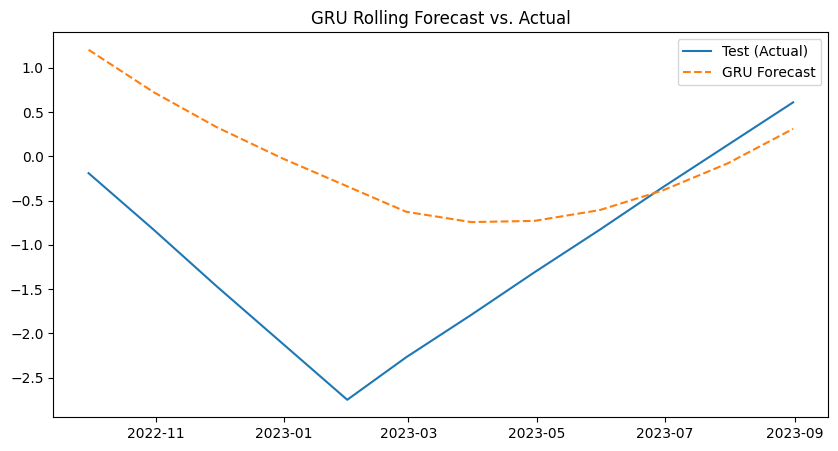

In [16]:
# Convert to numpy arrays for error metrics
gru_forecasts_np = np.array(gru_forecasts)
test_actual_np = test_np  # for clarity

# MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

# Calculate MAPE and MAE
gru_mape = mean_absolute_percentage_error(test_actual_np, gru_forecasts_np)
gru_mae = np.mean(np.abs(test_actual_np - gru_forecasts_np))
print(f"GRU Test MAPE: {gru_mape:.2f}%")
print(f"GRU Test MAE: {gru_mae:.2f}")

# Plot the results vs. actual
plt.figure(figsize=(10,5))
plt.plot(test_df_lstm.index, test_df_lstm['GDP Growth Rate (%)'], label='Test (Actual)')
plt.plot(test_df_lstm.index, gru_forecasts_np, label='GRU Forecast', linestyle='--')
plt.title('GRU Rolling Forecast vs. Actual')
plt.legend()
plt.show()

In [17]:
# ----------------------------------------
# Prediction Step for GRU
# ----------------------------------------

# Extract the last 12 GDP Growth Rate values
last_12_values = usa_data_for_GRU['GDP Growth Rate (%)'].values[-12:].astype(float)

# Convert to tensor and reshape to (1, 12)
input_sequence = torch.tensor(last_12_values, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 12)

print(f"Input sequence shape: {input_sequence.shape}")  # Should output: torch.Size([1, 12])

# Set the model to evaluation mode
model_gru.eval()

# Perform the prediction without tracking gradients
with torch.no_grad():
    predicted_growth_rate = model_gru(input_sequence).item()

print(f"Predicted GDP Growth Rate for the next period: {predicted_growth_rate:.4f}%")


Input sequence shape: torch.Size([1, 12])
Predicted GDP Growth Rate for the next period: 0.7719%


### **2.2 LSTM Model Implementation**

Epoch 10/100, Loss: 14.6015
Epoch 20/100, Loss: 14.2411
Epoch 30/100, Loss: 13.9024
Epoch 40/100, Loss: 13.5863
Epoch 50/100, Loss: 13.2929
Epoch 60/100, Loss: 13.0217
Epoch 70/100, Loss: 12.7717
Epoch 80/100, Loss: 12.5421
Epoch 90/100, Loss: 12.3317
Epoch 100/100, Loss: 12.1395
LSTM Model MAPE: 118.38%


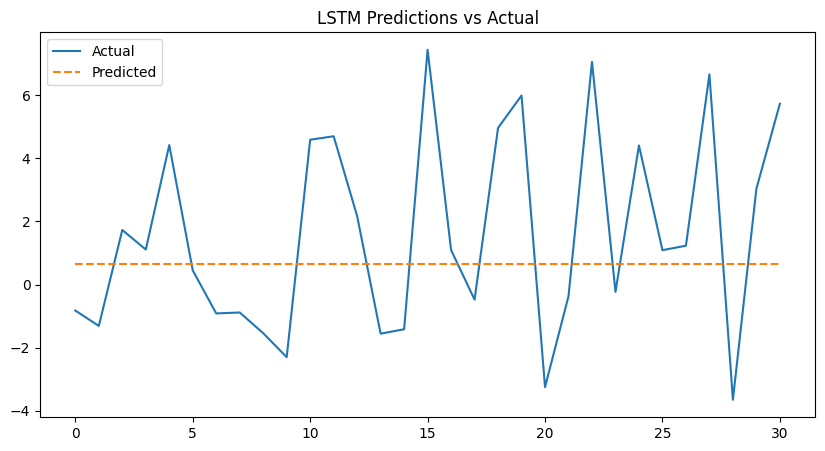

In [18]:
# Prepare the dataset
usa_data_for_LSTM = usa_data_for_Time_Series_Modeling
future_row_for_LSTM = future_row_for_time_series_modeling

# Convert to numpy arrays
features = [col for col in usa_data_for_LSTM.columns if col != 'GDP Growth Rate (%)']
X = usa_data_for_LSTM[features].values.astype(float)
y = usa_data_for_LSTM['GDP Growth Rate (%)'].values.astype(float)

# Create sequences
def create_sequences(data_x, data_y, window=12):
    sequence_x, sequence_y = [], []
    for i in range(len(data_x) - window):
        sequence_x.append(data_x[i:i + window])
        sequence_y.append(data_y[i + window])
    return np.array(sequence_x, dtype=np.float32), np.array(sequence_y, dtype=np.float32)

window_size = 12
X_seq, y_seq = create_sequences(X, y, window=window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Ensure data is properly shaped for LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model for predicting GDP Growth Rate (%)
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# Instantiate the LSTM model
input_size = X_train.shape[2]  # Number of features
lstm_model = LSTMRegressor(input_size=input_size, hidden_size=32).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion_lstm = nn.MSELoss()

# Train the LSTM model
epochs = 100
lstm_model.train()
for epoch in range(epochs):
    optimizer_lstm.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion_lstm(predictions, y_train_t)
    loss.backward()
    optimizer_lstm.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = lstm_model(sequence)
        lstm_predictions.append(pred.item())

# Calculate evaluation metrics for LSTM
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

lstm_mape = mean_absolute_percentage_error(y_test, lstm_predictions)
print(f"LSTM Model MAPE: {lstm_mape:.2f}%")

# Plot results for LSTM
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(lstm_predictions)), lstm_predictions, label="Predicted", linestyle='--')
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()


In [19]:
# ----------------------------------------
# Prediction Step for LSTM
# ----------------------------------------

# Ensure the model is in evaluation mode
lstm_model.eval()

# Extract the last 12 rows of feature data for prediction
# Combine training and test data for obtaining the latest sequences
full_features = usa_data_for_LSTM[features].values.astype(float)

last_12_features = full_features[-window_size:]  # Shape: (12, number_of_features)

# Convert the extracted features into a PyTorch tensor
input_sequence = torch.tensor(last_12_features, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 12, input_size)

print(f"Input sequence shape: {input_sequence.shape}")  # Should be torch.Size([1, 12, input_size])

# Step 3: Make the prediction using the trained LSTM model
with torch.no_grad():
    predicted_growth_rate = lstm_model(input_sequence).item()

# Step 4: Output the prediction
print(f"Predicted GDP Growth Rate for the next period: {predicted_growth_rate:.4f}%")

Input sequence shape: torch.Size([1, 12, 9])
Predicted GDP Growth Rate for the next period: 0.6503%


## **3. Feature Engineering**

## **3.1 Additional Meaning New-Features**

In [20]:
# Derived Features
usa_data['Industrial Growth'] = usa_data['Industrial Production'] / usa_data['Nonfarm Payrolls']
usa_data['Economic Activity Index'] = (usa_data['Personal Consumption Expenditures'] +
                                          usa_data['Industrial Production']) * usa_data['US Leading Index']

# Rolling Statistics
usa_data['CPI_3M_Rolling_Mean'] = usa_data['Consumer Price Index (CPI)'].rolling(window=3).mean()
usa_data['Unemployment_3M_Rolling_Std'] = usa_data['Unemployment Rate (%)'].rolling(window=3).std()

# Lagged Features
for col in ['Inflation Rate (%)', '10-Year Treasury Yield', 'Unemployment Rate (%)', 'Industrial Production']:
    usa_data[f'{col}_Lag_1'] = usa_data[col].shift(1)

# Handle Missing Values
usa_data.fillna(method='bfill', inplace=True)
usa_data.fillna(method='ffill', inplace=True)

# Verify the Engineered Data
print("\nEngineered Features Preview:")
usa_data.head()



Engineered Features Preview:


,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI),GDP Growth Rate (%),Industrial Growth,Economic Activity Index,CPI_3M_Rolling_Mean,Unemployment_3M_Rolling_Std,Inflation Rate (%)_Lag_1,10-Year Treasury Yield_Lag_1,Unemployment Rate (%)_Lag_1,Industrial Production_Lag_1
Date,,,,,,,,,,,,,,,,,,
2010-01-31,7.460000,2.640000,6.390000,3.73,129795.0,89.1897,10056.1,0.54,217.488,4.820000,0.000687,5478.456438,217.374000,3.511942,7.460000,3.73,2.640000,89.1897
2010-02-28,3.130000,9.320000,-0.660000,3.69,129702.0,89.5046,10093.4,0.76,217.281,-1.480000,0.000690,7739.007496,217.374000,3.511942,7.460000,3.73,2.640000,89.1897
2010-03-31,7.200000,4.100000,8.220000,3.73,129865.0,90.1356,10156.0,1.10,217.353,-0.696667,0.000694,11270.749160,217.374000,3.511942,3.130000,3.69,9.320000,89.5046
2010-04-30,6.653333,4.246667,6.593333,3.85,130115.0,90.4607,10182.3,1.14,217.403,0.086667,0.000695,11710.947198,217.345667,2.972334,7.200000,3.73,4.100000,90.1356
2010-05-31,6.106667,4.393333,4.966667,3.42,130645.0,91.7014,10210.8,1.42,217.290,0.870000,0.000702,14629.551988,217.348667,0.146667,6.653333,3.85,4.246667,90.4607


## **3.2 Noise-Reduction-Purposed New-Features**

In [21]:
# 1. Create longer lagged features (3-month and 6-month lags for key features)
usa_data['Inflation Rate (%)_Lag3'] = usa_data['Inflation Rate (%)'].shift(3)
usa_data['Inflation Rate (%)_Lag6'] = usa_data['Inflation Rate (%)'].shift(6)
usa_data['Interest Rate (%)_Lag3'] = usa_data['Interest Rate (%)'].shift(3)
usa_data['Interest Rate (%)_Lag6'] = usa_data['Interest Rate (%)'].shift(6)

# 2. Add longer rolling statistics (6-month and 12-month rolling averages for key features)
usa_data['Inflation Rate (%)_MA6'] = usa_data['Inflation Rate (%)'].rolling(window=6).mean()
usa_data['Inflation Rate (%)_MA12'] = usa_data['Inflation Rate (%)'].rolling(window=12).mean()
usa_data['Interest Rate (%)_MA6'] = usa_data['Interest Rate (%)'].rolling(window=6).mean()
usa_data['Interest Rate (%)_MA12'] = usa_data['Interest Rate (%)'].rolling(window=12).mean()

# 3. Create new feature interactions
usa_data['Inflation_Interest_Ratio'] = usa_data['Inflation Rate (%)'] / usa_data['Interest Rate (%)']
usa_data['Employment_Gap'] = 100 - usa_data['Unemployment Rate (%)']


## **3.3 Splitting and Scaling the New Dataset**

In [22]:
features = usa_data.drop(columns=['GDP Growth Rate (%)'])  # Exclude the target
target = usa_data['GDP Growth Rate (%)']

scaler = MinMaxScaler()
# Scale features
scaled_features = scaler.fit_transform(features)
# Convert back to a DataFrame for readability
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

# Combine scaled features with the target for final dataset
final_data = pd.concat([scaled_features_df, target], axis=1)

usa_data = final_data

# Handle Missing Values
usa_data.fillna(method='bfill', inplace=True)
usa_data.fillna(method='ffill', inplace=True)

# Verify the structure
usa_data.head()



,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI),Industrial Growth,...,Inflation Rate (%)_Lag6,Interest Rate (%)_Lag3,Interest Rate (%)_Lag6,Inflation Rate (%)_MA6,Inflation Rate (%)_MA12,Interest Rate (%)_MA6,Interest Rate (%)_MA12,Inflation_Interest_Ratio,Employment_Gap,GDP Growth Rate (%)
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,0.752786,0.042312,0.675287,0.827128,0.003449,0.232126,0.000000,0.019608,0.003208,0.437074,...,0.752786,0.675287,0.675287,0.649299,0.399917,0.502006,0.300974,0.728010,0.957688,4.820000
2010-02-28,0.314083,0.731682,0.000000,0.816489,0.000000,0.248340,0.004159,0.163399,0.000910,0.468472,...,0.752786,0.675287,0.675287,0.649299,0.399917,0.502006,0.300974,0.668363,0.268318,-1.480000
2010-03-31,0.726444,0.192982,0.850575,0.827128,0.006045,0.280827,0.011139,0.385621,0.001709,0.511398,...,0.752786,0.675287,0.675287,0.649299,0.399917,0.502006,0.300974,0.725068,0.807018,-0.696667
2010-04-30,0.671057,0.208118,0.694764,0.859043,0.015316,0.297566,0.014071,0.411765,0.002264,0.523922,...,0.752786,0.675287,0.675287,0.649299,0.399917,0.502006,0.300974,0.726412,0.791882,0.086667
2010-05-31,0.615670,0.223254,0.538953,0.744681,0.034971,0.361445,0.017249,0.594771,0.001010,0.595698,...,0.752786,0.000000,0.675287,0.649299,0.399917,0.502006,0.300974,0.728637,0.776746,0.870000


## **4. Exploratory Data Analysis**

### **4.1 Visualizations**


Correlation with GDP Growth Rate (%):
GDP Growth Rate (%)                  1.000000
Inflation Rate (%)_MA6               0.303531
Inflation Rate (%)_Lag3              0.278667
Personal Consumption Expenditures    0.272493
Inflation Rate (%)_Lag_1             0.252212
Consumer Price Index (CPI)           0.244393
CPI_3M_Rolling_Mean                  0.242533
Nonfarm Payrolls                     0.235823
Unemployment_3M_Rolling_Std          0.215786
Inflation Rate (%)_MA12              0.212323
Industrial Production                0.208628
Inflation Rate (%)                   0.204521
Industrial Production_Lag_1          0.184168
Inflation_Interest_Ratio             0.164823
Unemployment Rate (%)_Lag_1          0.160973
Interest Rate (%)_MA6                0.146626
Interest Rate (%)_Lag3               0.138465
10-Year Treasury Yield               0.132675
Unemployment Rate (%)                0.128363
Employment_Gap                       0.128363
US Leading Index                     0.11

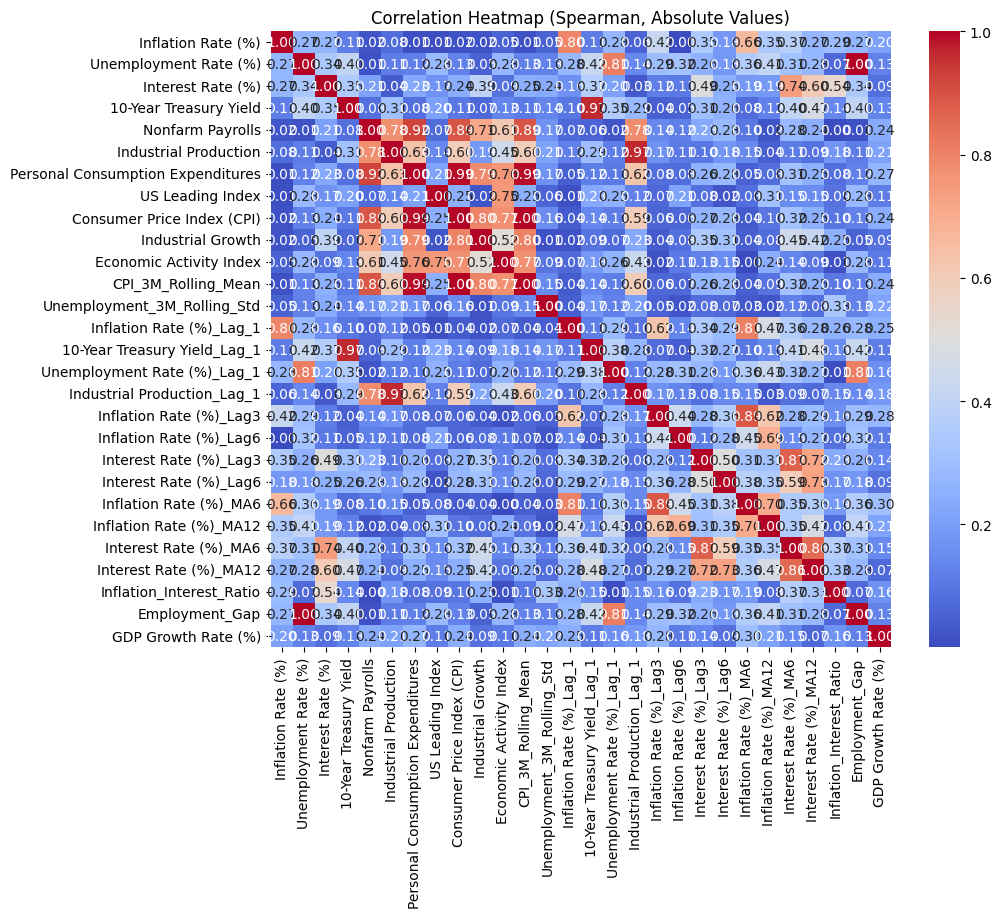

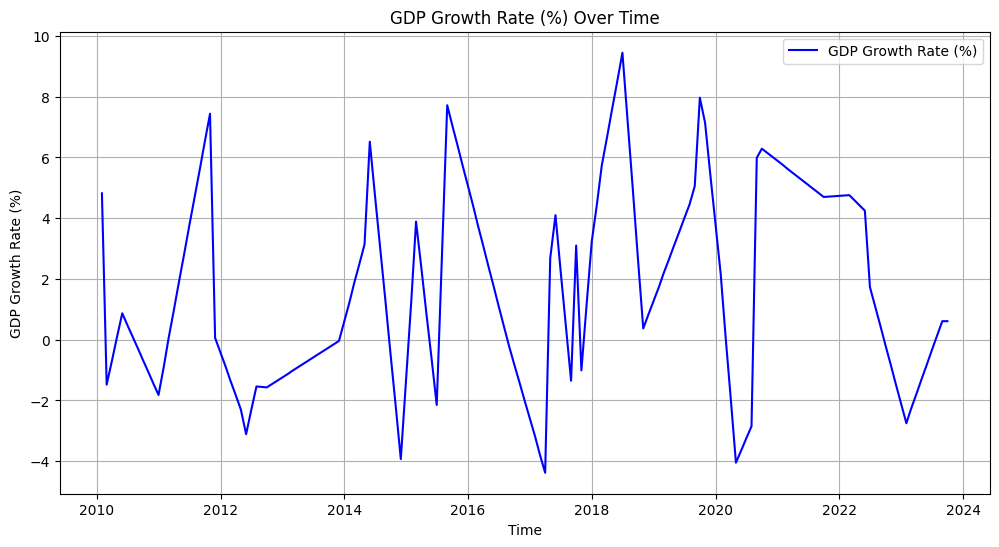

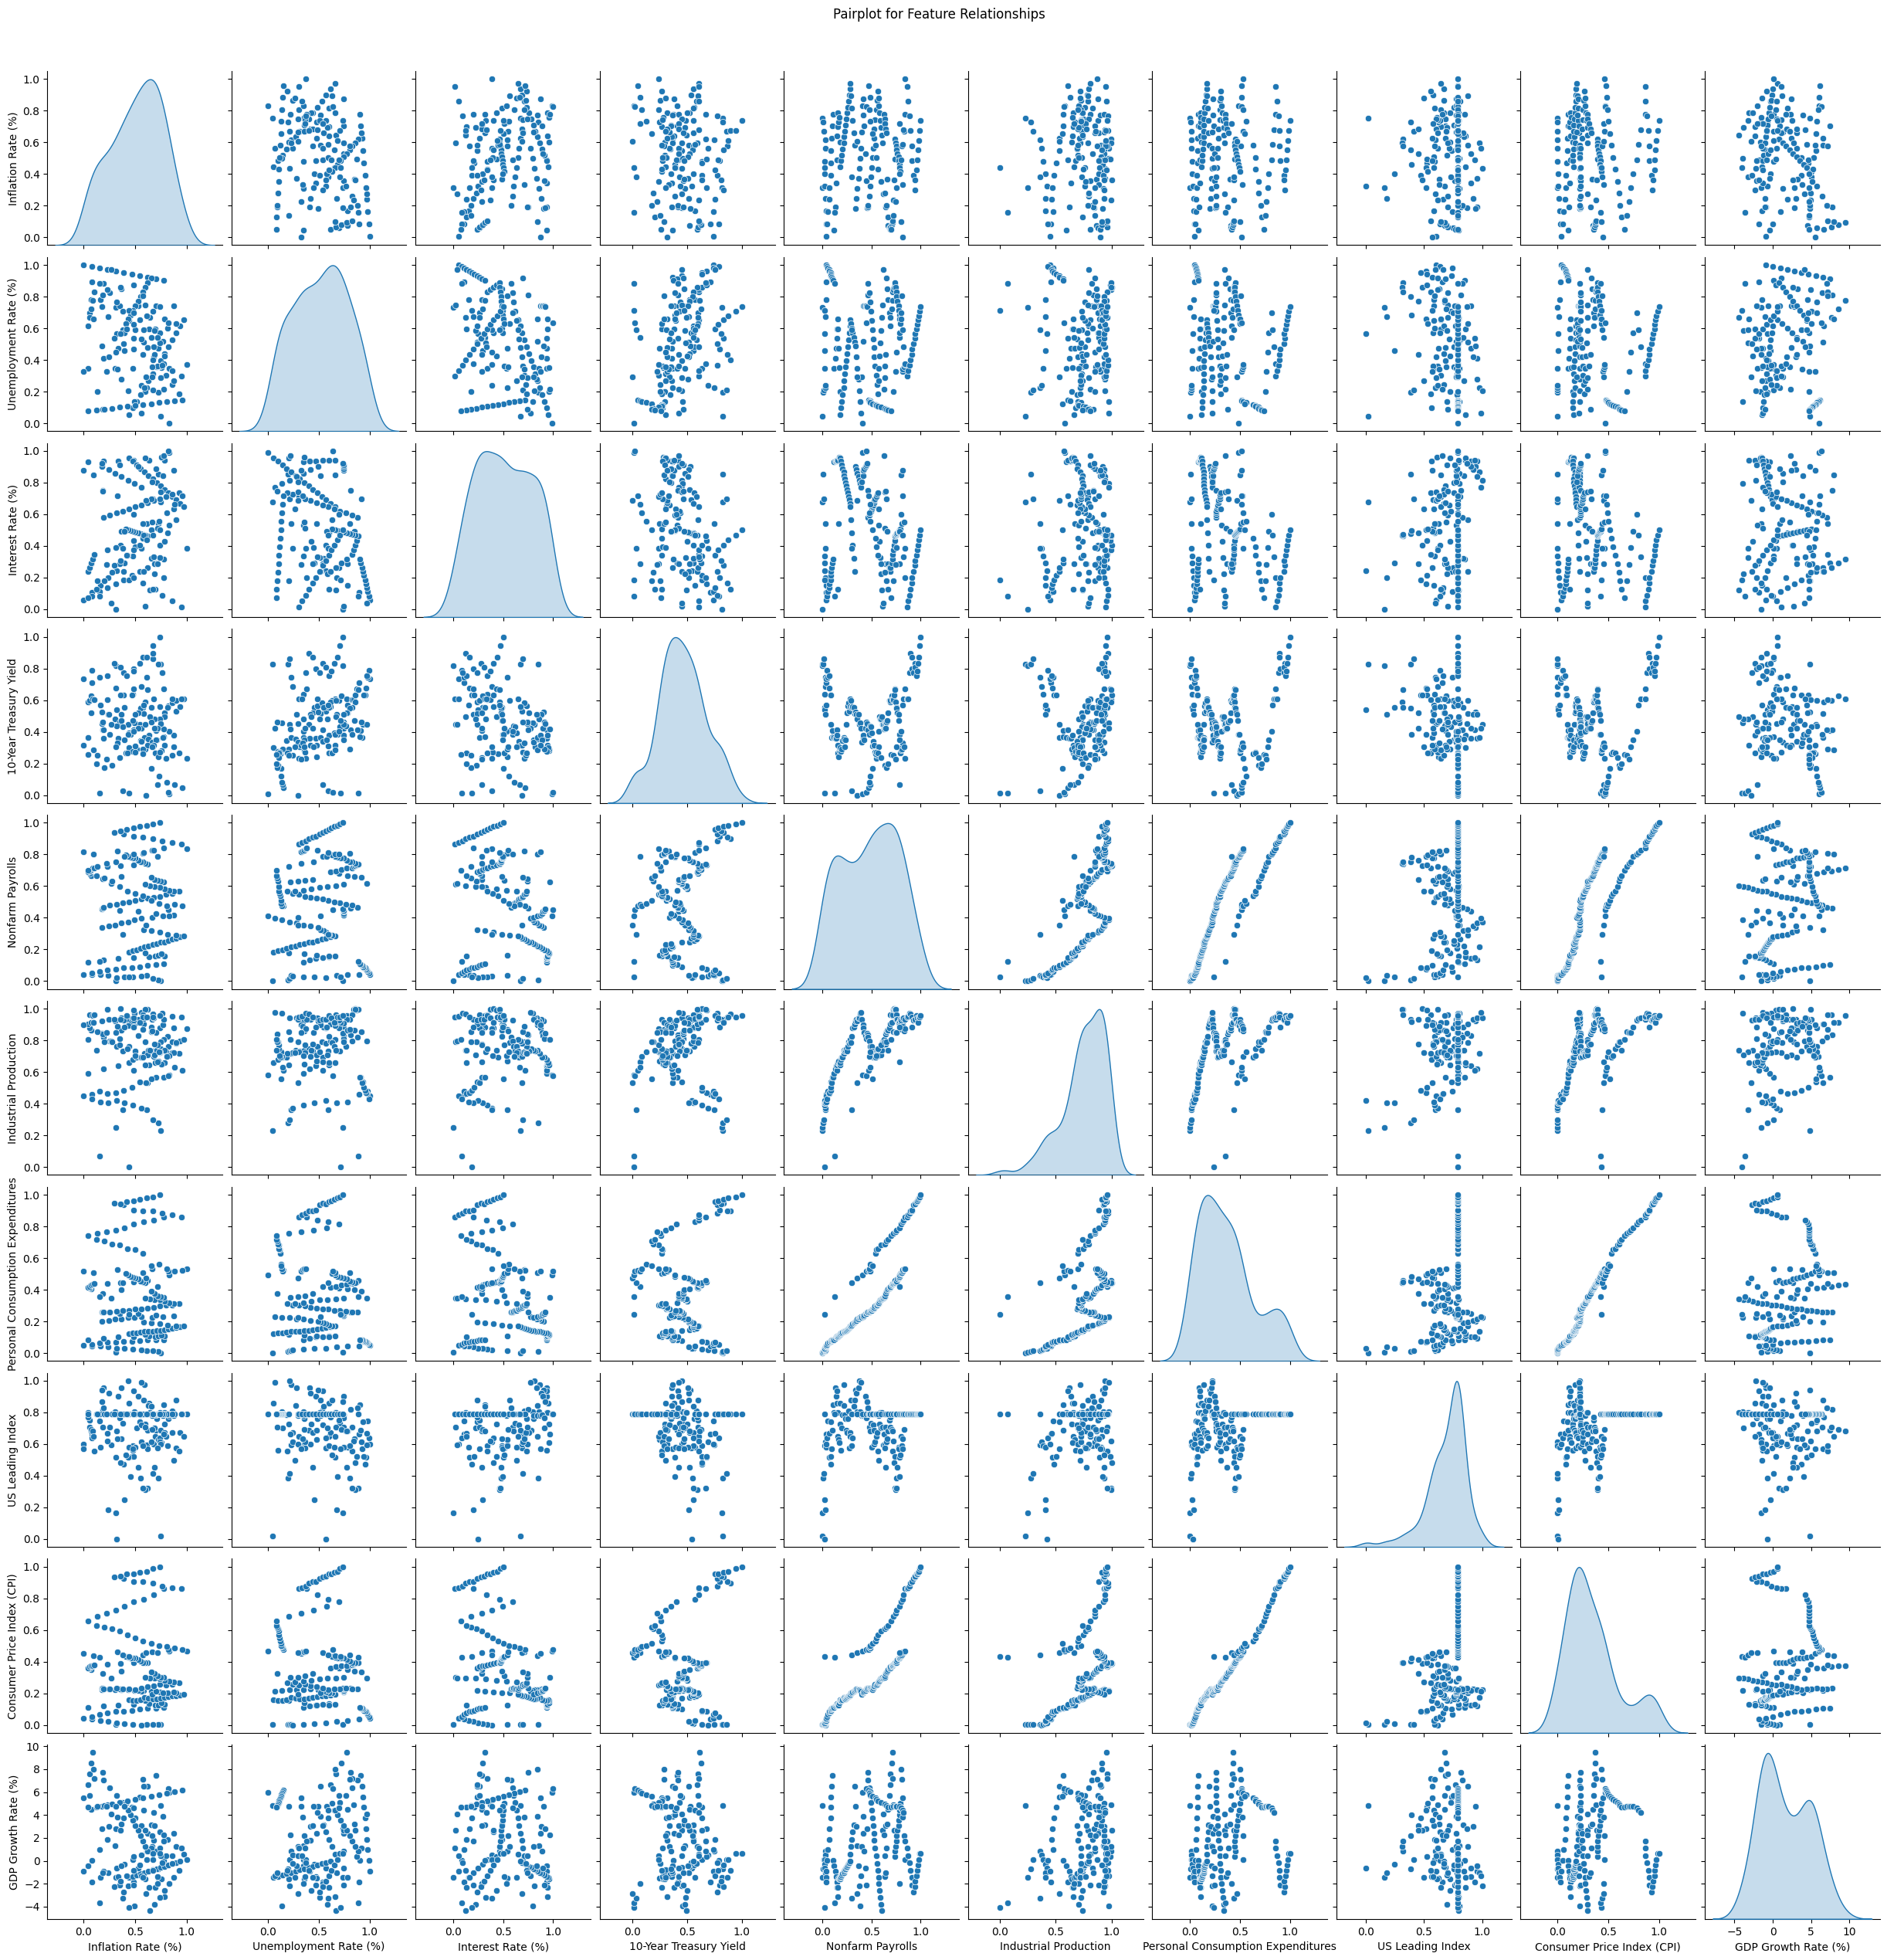

In [23]:
# Ensure time-series correlation calculation using Spearman and absolute values
correlation = usa_data.corr(method='spearman').abs()  # Spearman correlation and absolute values

# Sort correlations with GDP Growth Rate (%)
gdp_correlation = correlation['GDP Growth Rate (%)'].sort_values(ascending=False)
print("\nCorrelation with GDP Growth Rate (%):")
print(gdp_correlation)

# Plot heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Spearman, Absolute Values)")
plt.show()

# Line plot for GDP Growth Rate over time
plt.figure(figsize=(12, 6))
plt.plot(usa_data.index, usa_data['GDP Growth Rate (%)'], label='GDP Growth Rate (%)', color='blue')
plt.title("GDP Growth Rate (%) Over Time")
plt.xlabel("Time")
plt.ylabel("GDP Growth Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Pairplot for feature relationships
selected_features = ['Inflation Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)',
                     '10-Year Treasury Yield','Nonfarm Payrolls','Industrial Production',
                     'Personal Consumption Expenditures','US Leading Index','Consumer Price Index (CPI)']
sns.pairplot(usa_data, vars=selected_features + ['GDP Growth Rate (%)'], diag_kind='kde', height=2.5)
plt.suptitle("Pairplot for Feature Relationships", y=1.02)
plt.show()


## **5. Deep Learning Model Development**

In [24]:
# Shift 'GDP Growth Rate (%)' column upwards by one row to predict next day's price
usa_data['GDP Growth Rate (%)'] = usa_data['GDP Growth Rate (%)'].shift(-1)

# Drop the Date column as it is not a feature
usa_data = usa_data.drop(columns=['Date', 'Country'], errors='ignore')

# Separate the last row for future prediction
future_row = usa_data.iloc[[-1]]
usa_data = usa_data.iloc[:-1]

# Split the data into features (X) and prediction target (y)
X = usa_data.drop(columns=['GDP Growth Rate (%)'])  # Features
y = usa_data['GDP Growth Rate (%)']                # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets for verification
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

# Display the future row for prediction verification
print("\n----------------------------------------------------------------------------\n")
print("\nFuture row for prediction:")
future_row

Training set shape (X_train, y_train): (131, 27) (131,)
Testing set shape (X_test, y_test): (33, 27) (33,)

----------------------------------------------------------------------------


Future row for prediction:


,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI),Industrial Growth,...,Inflation Rate (%)_Lag6,Interest Rate (%)_Lag3,Interest Rate (%)_Lag6,Inflation Rate (%)_MA6,Inflation Rate (%)_MA12,Interest Rate (%)_MA6,Interest Rate (%)_MA12,Inflation_Interest_Ratio,Employment_Gap,GDP Growth Rate (%)
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-30,0.738602,0.73581,0.501916,1.0,1.0,0.959032,1.0,0.79085,1.0,0.138779,...,0.360834,0.405036,0.308155,0.618444,0.524335,0.37857,0.228462,0.732358,0.26419,NaN


### **5.1 Random Forest Model - ML Classics for Comparison**

In [25]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configure and run the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Configure the model

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)

y_train = y_train.values

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best R^2 Score: 0.36533100621704867


In [26]:
# Retrieve the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the testing set
y_pred = best_rf_model.predict(X_test)
print("\nModel Evaluation:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Predict the GDP Growth Rate for the future row
future_prediction = best_rf_model.predict(future_row.drop(columns=['GDP Growth Rate (%)'], errors='ignore'))
print("\nPredicted GDP Growth Rate (%) for the future row:", future_prediction)


Model Evaluation:
Mean Squared Error: 3.514167608261377
R^2 Score: 0.7355530026973512

Predicted GDP Growth Rate (%) for the future row: [0.57186733]


### **5.2 Transformer Model for Enhanced Forecasting**

Epoch 10/120, Loss: 10.2632
Epoch 20/120, Loss: 9.1212
Epoch 30/120, Loss: 5.7142
Epoch 40/120, Loss: 3.4498
Epoch 50/120, Loss: 3.0135
Epoch 60/120, Loss: 2.2524
Epoch 70/120, Loss: 1.5563
Epoch 80/120, Loss: 1.0100
Epoch 90/120, Loss: 0.6840
Epoch 100/120, Loss: 0.5836
Epoch 110/120, Loss: 0.3476
Epoch 120/120, Loss: 0.3584

RMSE: 1.8488
R² Score: 0.6431


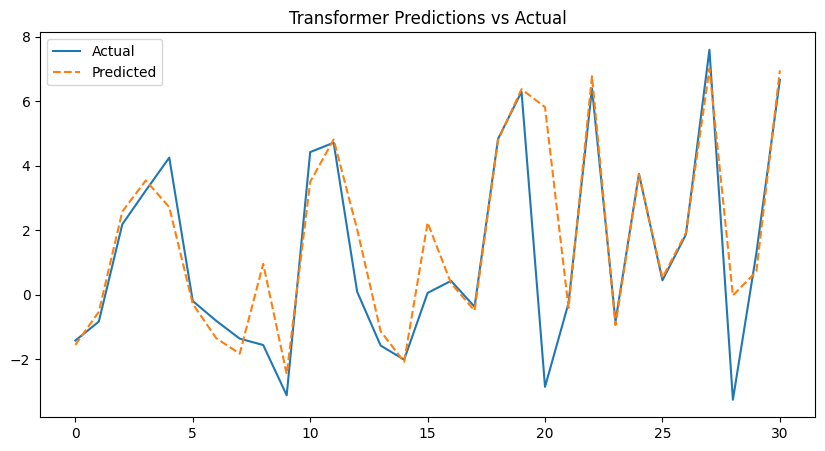

In [33]:
# Define the Transformer-based model for predicting GDP Growth Rate (%)
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, num_heads=4, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_proj(x)  # Project input to the transformer dimension
        x = self.transformer(x)  # Pass through the transformer encoder
        x = self.fc(x[:, -1, :])  # Take the output of the last time step for prediction
        return x.squeeze(-1)

# Prepare sequences for time-series modeling
def create_sequences(data_x, data_y, window=12):
    sequence_x, sequence_y = [], []
    for i in range(len(data_x) - window):
        sequence_x.append(data_x[i:i + window])
        sequence_y.append(data_y[i + window])
    return np.array(sequence_x, dtype=np.float32), np.array(sequence_y, dtype=np.float32)

# Data preparation
features = [col for col in usa_data.columns if col != 'GDP Growth Rate (%)']
X = usa_data[features].values.astype(float)
y = usa_data['GDP Growth Rate (%)'].values.astype(float)
window_size = 12
X_seq, y_seq = create_sequences(X, y, window=window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Ensure data is properly shaped for Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# Instantiate the Transformer model
input_size = X_train.shape[2]  # Number of features
transformer_model = TransformerRegressor(
    input_size=input_size, num_heads=4, hidden_size=64, num_layers=2, dropout=0.1
).to(device)
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.001)
criterion_transformer = nn.MSELoss()

# Train the Transformer model
epochs = 120
transformer_model.train()
for epoch in range(epochs):
    optimizer_transformer.zero_grad()
    predictions = transformer_model(X_train_t)
    loss = criterion_transformer(predictions, y_train_t)
    loss.backward()
    optimizer_transformer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the Transformer model
transformer_model.eval()
transformer_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)  # Add batch dimension
        pred = transformer_model(sequence)
        transformer_predictions.append(pred.item())

# Calculate evaluation metrics for the Transformer model
rmse = np.sqrt(np.mean((y_test - transformer_predictions) ** 2))
r2 = 1 - (np.sum((y_test - transformer_predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"\nRMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot results for the Transformer model
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(transformer_predictions)), transformer_predictions, label="Predicted", linestyle='--')
plt.title("Transformer Predictions vs Actual")
plt.legend()
plt.show()



In [34]:
# ----------------------------------------
# Prediction Step for Transformer
# ----------------------------------------

# Ensure the Transformer model is in evaluation mode
transformer_model.eval()

# Extract the last 'window_size' rows of features using .iloc for row selection and direct column selection
last_sequence = usa_data.iloc[-window_size:, :][features].values.astype(float)  # Shape: [12, 27]

# Verify the shape of last_sequence
print(f"Shape of last_sequence: {last_sequence.shape}")  # Should be [12, 27]

# Convert the extracted sequence to a PyTorch tensor
# Reshape to [1, 12, 27] to match [batch_size, sequence_length, input_size]
input_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: [1, 12, 27]

# Make the prediction using the Transformer model
with torch.no_grad():
    prediction_tensor = transformer_model(input_tensor)  # Shape: [1]
    predicted_growth_rate = prediction_tensor.item()

# Print the predicted GDP Growth Rate
print(f"\nPredicted GDP Growth Rate for the next period: {predicted_growth_rate:.4f}%")

predicted_growth_rate_for_transformer = predicted_growth_rate



Shape of last_sequence: (12, 27)

Predicted GDP Growth Rate for the next period: 0.7282%


### **5.3 TCN (Temporal Convolutional Network) for Sequential Learning**

Epoch 10/110, Loss: 8.1983
Epoch 20/110, Loss: 4.4715
Epoch 30/110, Loss: 2.8003
Epoch 40/110, Loss: 2.0789
Epoch 50/110, Loss: 2.0112
Epoch 60/110, Loss: 1.2157
Epoch 70/110, Loss: 1.2662
Epoch 80/110, Loss: 1.2365
Epoch 90/110, Loss: 1.1274
Epoch 100/110, Loss: 1.4249
Epoch 110/110, Loss: 0.7610
TCN Model RMSE: 1.5228
TCN Model R²: 0.7578


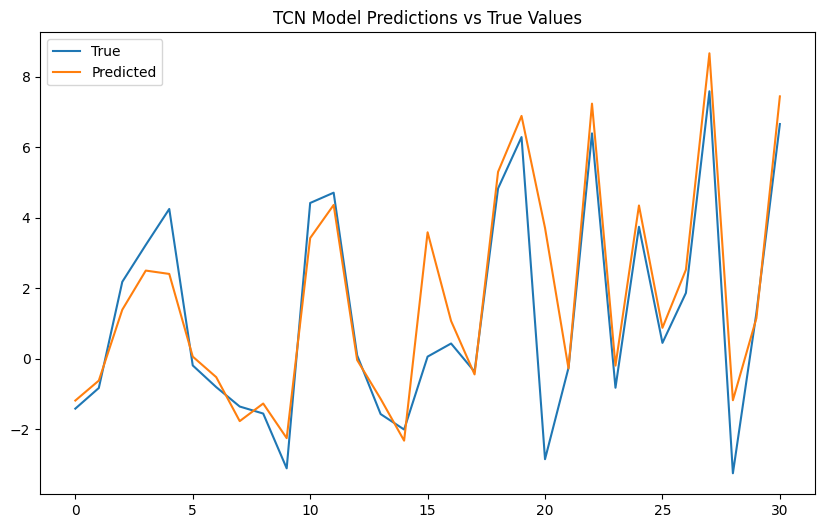

In [37]:
# Define a TCN block
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate, dropout_rate=0.2):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size - 1) * dilation_rate // 2,  # Correct padding
            dilation=dilation_rate,
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.residual = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout(x)
        if self.residual:
            residual = self.residual(residual)
        return self.batch_norm(x + residual)

# Define the TCN model
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout_rate=0.2):
        super(TCNModel, self).__init__()
        self.tcn = nn.Sequential(
            TCNBlock(input_size, num_channels, kernel_size, dilation_rate=1, dropout_rate=dropout_rate),
            TCNBlock(num_channels, num_channels, kernel_size, dilation_rate=2, dropout_rate=dropout_rate),
            TCNBlock(num_channels, num_channels, kernel_size, dilation_rate=4, dropout_rate=dropout_rate),
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global pooling to reduce seq_len to 1
        self.fc = nn.Linear(num_channels, output_size)

    def forward(self, x):
        x = self.tcn(x)  # Shape: (batch_size, num_channels, seq_len)
        x = self.global_pool(x).squeeze(-1)  # Shape: (batch_size, num_channels)
        x = self.fc(x)  # Shape: (batch_size, output_size)
        return x

# Prepare the dataset
def prepare_data(usa_data, target_column, sequence_length=12):
    X, y = [], []
    for i in range(len(usa_data) - sequence_length):
        X.append(usa_data.iloc[i:i + sequence_length, :-1].values)
        y.append(usa_data.iloc[i + sequence_length][target_column])
    X = np.array(X, dtype=np.float32).transpose(0, 2, 1)  # Shape: [samples, features, time]
    y = np.array(y, dtype=np.float32)
    return torch.tensor(X), torch.tensor(y)

# Load and prepare data
target_column = "GDP Growth Rate (%)"
sequence_length = 12  # 12 months of historical data
X, y = prepare_data(usa_data, target_column, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
input_size = X.shape[1]  # Number of features
output_size = 1  # Predicting a single target value
num_channels = 64  # Number of channels for TCN layers
kernel_size = 3  # Kernel size for convolutional layers

tcn_model = TCNModel(input_size=input_size, output_size=output_size, num_channels=num_channels, kernel_size=kernel_size)
# Define optimizer and loss function
optimizer = optim.Adam(tcn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
num_epochs = 110
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1, num_epochs + 1):
    tcn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = tcn_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print results every 10 epochs
    if epoch % 10 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


# Evaluate the model
tcn_model.eval()
with torch.no_grad():
    y_pred = tcn_model(X_test).squeeze()
#    mse = criterion(y_pred, y_test)
#    print(f"TCN Model MSE: {mse.item():.4f}")
    rmse = np.sqrt(mean_squared_error(y_test.numpy(), y_pred.numpy()))
    print(f"TCN Model RMSE: {rmse:.4f}")
    r2 = r2_score(y_test.numpy(), y_pred.numpy())
    print(f"TCN Model R²: {r2:.4f}")

# Plot predictions vs actual values
y_pred = y_pred.numpy()
y_test = y_test.numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("TCN Model Predictions vs True Values")
plt.show()


In [38]:
# ----------------------------------------
# Prediction Step for TCN
# ----------------------------------------

def predict_next_gdp_tcn(model, data, features, sequence_length=12, device='cpu'):
    """
    Predict the next GDP Growth Rate using a trained TCN model.

    Parameters:
    - model (nn.Module): Trained TCN model.
    - data (pd.DataFrame): DataFrame containing the feature columns.
    - features (list): List of feature column names.
    - sequence_length (int): Number of past time steps to use for prediction.
    - device (torch.device or str): Device to perform computation on.

    Returns:
    - float: Predicted GDP Growth Rate.
    """
    model.eval()

    # Ensure there are enough rows
    if len(data) < sequence_length:
        raise ValueError(f"Data has only {len(data)} rows, but requires at least {sequence_length} rows.")

    # Extract the last 'sequence_length' rows of features
    last_sequence = data.iloc[-sequence_length:, :][features].values.astype(float)  # Shape: [12, 27]

    # Convert to tensor and reshape to [1, 27, 12]
    # Transpose to match [features, time_steps]
    input_tensor = torch.tensor(last_sequence, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)  # Shape: [1, 27, 12]

    with torch.no_grad():
        prediction = model(input_tensor).item()

    return prediction

# Corrected: Use 'usa_data' instead of 'usa_data_for_Time_Series_Modeling'
predicted_growth_rate = predict_next_gdp_tcn(
    model=tcn_model,
    data=usa_data,  # Correct DataFrame reference
    features=features,  # Ensure this includes all 27 features
    sequence_length=12,
    device=device  # Ensure this matches the device used during training ('cpu' or 'cuda')
)

print(f"\nPredicted GDP Growth Rate for the next period: {predicted_growth_rate:.4f}%")

predicted_growth_rate_for_tcn = predicted_growth_rate



Predicted GDP Growth Rate for the next period: 1.2485%


### **5.3 WaveNet-Style Model for Temporal Patterns**

Input shape: torch.Size([152, 27, 12])
Input tensor shape: torch.Size([152, 27, 12])
Epoch 10/140, Loss: 10.4412
Epoch 20/140, Loss: 10.3288
Epoch 30/140, Loss: 9.9101
Epoch 40/140, Loss: 8.3323
Epoch 50/140, Loss: 7.9899
Epoch 60/140, Loss: 7.1399
Epoch 70/140, Loss: 5.7603
Epoch 80/140, Loss: 4.2106
Epoch 90/140, Loss: 2.9140
Epoch 100/140, Loss: 2.4168
Epoch 110/140, Loss: 1.9109
Epoch 120/140, Loss: 1.6660
Epoch 130/140, Loss: 1.2202
Epoch 140/140, Loss: 0.8935
WaveNet Model RMSE: 1.2696
WaveNet Model R²: 0.8317


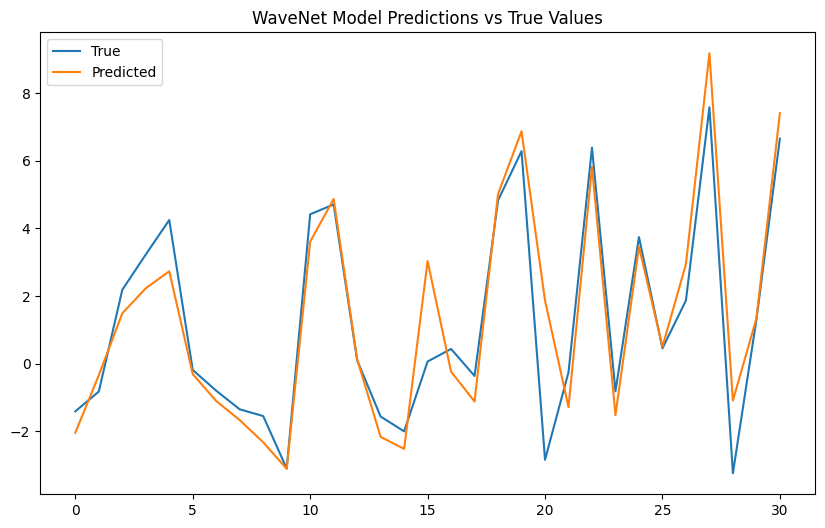

In [39]:
# Corrected WaveNet Implementation
class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(WaveNetBlock, self).__init__()
        self.padding = (kernel_size - 1) * dilation_rate
        self.dilated_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation_rate
        )
        self.gate_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation_rate
        )
        self.residual_conv = nn.Conv1d(out_channels, out_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        conv = torch.tanh(self.dilated_conv(x))
        gate = torch.sigmoid(self.gate_conv(x))
        output = conv * gate
        residual = self.residual_conv(output)
        skip = self.skip_conv(output)

        # Adjust sizes
        residual = residual[..., :x.size(-1)]
        skip = skip[..., :x.size(-1)]
        return (x + residual), skip

class WaveNet(nn.Module):
    def __init__(self, input_channels, num_blocks, kernel_size, dilation_rates):
        super(WaveNet, self).__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(input_channels, input_channels, kernel_size, dilation_rate)
            for dilation_rate in dilation_rates
        ])
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Pool time dimension to 1
        self.final_fc = nn.Linear(input_channels, 1)  # Fully connected for single output

    def forward(self, x):
        skip_connections = []
        for block in self.blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        x = sum(skip_connections)  # Sum all skip connections
        x = torch.relu(x)
        x = self.global_pool(x).squeeze(-1)  # Reduce to [batch_size, input_channels]
        x = self.final_fc(x)  # Output a single value
        return x


# Prepare Data
def prepare_data(usa_data, target_column, sequence_length=12):
    X, y = [], []
    for i in range(len(usa_data) - sequence_length):
        X.append(usa_data.iloc[i:i + sequence_length, :-1].values.T)  # [features, time]
        y.append(usa_data.iloc[i + sequence_length][target_column])
    X = np.array(X, dtype=np.float32)  # [samples, features, time]
    y = np.array(y, dtype=np.float32)
    return torch.tensor(X), torch.tensor(y)

# Prepare dataset
X, y = prepare_data(usa_data, target_column, sequence_length)
input_channels = X.shape[1]  # Number of features (not 1)

# Ensure input shape is [batch_size, input_channels, sequence_length]
print(f"Input shape: {X.shape}")  # Debugging shape
print(f"Input tensor shape: {X.shape}")  # Debugging
# Expected: [samples, features, time] e.g., [152, 28, 12]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Model
input_channels = X.shape[1]  # Number of features (28 in this case)
num_blocks = 6
kernel_size = 2
dilation_rates = [2**i for i in range(num_blocks)]

wavenet_model = WaveNet(input_channels=input_channels, num_blocks=num_blocks, kernel_size=kernel_size, dilation_rates=dilation_rates)

# Training Setup
optimizer = optim.Adam(wavenet_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train Model
num_epochs = 140
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1, num_epochs + 1):
    wavenet_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = wavenet_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print results every 10 epochs
    if epoch % 10 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate Model
wavenet_model.eval()
with torch.no_grad():
    y_pred = wavenet_model(X_test).squeeze()

    # Convert tensors to numpy arrays for metric calculation
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_test_np - y_pred_np) ** 2))

    # Calculate R²
    r2 = 1 - (np.sum((y_test_np - y_pred_np) ** 2) / np.sum((y_test_np - np.mean(y_test_np)) ** 2))

    print(f"WaveNet Model RMSE: {rmse:.4f}")
    print(f"WaveNet Model R²: {r2:.4f}")

# Plot Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label="True")
plt.plot(y_pred_np, label="Predicted")
plt.legend()
plt.title("WaveNet Model Predictions vs True Values")
plt.show()


In [40]:
# ----------------------------------------
# Prediction Step for WaveNet
# ----------------------------------------

def predict_next_gdp_wavenet(model, data, features, sequence_length=12, device='cpu'):
    """
    Predict the next GDP Growth Rate using a trained WaveNet model.

    Parameters:
    - model (nn.Module): Trained WaveNet model.
    - data (pd.DataFrame): DataFrame containing the feature columns.
    - features (list): List of feature column names.
    - sequence_length (int): Number of past time steps to use for prediction.
    - device (torch.device or str): Device to perform computation on.

    Returns:
    - float: Predicted GDP Growth Rate.
    """
    model.eval()

    # Extract the last 'sequence_length' rows of features using the 'features' list
    last_sequence = data.iloc[-sequence_length:, :][features].values.astype(float)  # Shape: [12, 27]

    # Convert to tensor and reshape to [1, 27, 12]
    # Transpose to match [input_channels, sequence_length]
    input_tensor = torch.tensor(last_sequence, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)  # Shape: [1, 27, 12]

    with torch.no_grad():
        prediction = model(input_tensor).item()

    return prediction

# Make the prediction using the corrected DataFrame reference
predicted_growth_rate = predict_next_gdp_wavenet(
    model=wavenet_model,
    data=usa_data,  # Correct DataFrame reference
    features=features,  # Ensure this includes all 27 features
    sequence_length=12,
    device=device  # Ensure this matches the device used during training ('cpu' or 'cuda')
)

print(f"\nPredicted GDP Growth Rate for the next period: {predicted_growth_rate:.4f}%")

predicted_growth_rate_for_wavenet = predicted_growth_rate



Predicted GDP Growth Rate for the next period: -0.8247%


In [41]:
overall_predicted_growth_rate = (predicted_growth_rate_for_wavenet+predicted_growth_rate_for_tcn+predicted_growth_rate_for_transformer)/3

print(f"\nPredicted GDP Growth Rate for the next period\n\nAverage of all DL Architectures :\n {overall_predicted_growth_rate:.4f}%")



Predicted GDP Growth Rate for the next period

Average of all DL Architectures :
 0.3840%


In [42]:
# Once more, Build the Gradio Interface
def ask_bot(query):
    return generate_answer(query)

interface = gr.Interface(
    fn=ask_bot,
    inputs="text",
    outputs="text",
    title="Economic Insights Bot",
    description="Ask questions about economic concepts like GDP, inflation, and more!"
)

# Launch the Interface
interface.launch()

# User Prompt
print("Thanks for exploring! Are there any additional questions you'd like to ask?")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://97e0516d226b2fb777.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Thanks for exploring! Are there any additional questions you'd like to ask?
